https://stephenholiday.com/articles/2011/gender-prediction-with-python/

In [207]:
import pandas as pd
import numpy as np
import itertools
import os
from time import time, ctime
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, classification, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


In [73]:
df = pd.read_csv('./users.gender.golden.csv')
print df.shape
df.head()

(121335, 9)


,user_id,username,freq,male.prob,fname.gender,male.prob2,fname.gender2,Name,pic.gender
0,5.0,billion,2.0,1.0000,male,0.920000,male,NaN,NaN
1,63.0,paddyshyam,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,64.0,ArmenSoft,1.0,1.0000,male,NaN,NaN,NaN,NaN
3,128.0,okbookman,1.0,0.9945,male,0.998834,male,NaN,NaN
4,215.0,revitupmedia,1.0,1.0000,male,NaN,NaN,215_profile.jpg,NaN


In [74]:
# df['male.prob'].describe()

In [75]:
df['fname.gender'].value_counts(dropna=False)

NaN       71935
male      40389
female     9011
Name: fname.gender, dtype: int64

In [76]:
pre9=df[(~df['fname.gender'].isnull())][['username','fname.gender']]
pre9.shape

(49400, 2)

In [77]:
pre1=df[(~df['fname.gender'].isnull())& abs(df['male.prob']-0.5)>0.4][['username','fname.gender']]
pre1.shape

(49260, 2)

In [78]:
def extract_features2(name, N=2):
    name = name.lower()
    features = {'nchar': len(name)}
    for i in range(len(name)-N):
        features["count({})".format(name[i:i+N])] = name.lower().count(name[i:i+N])
    for letter in 'abcdefghijklmnopqrstuvwxyz':
        features["count({})".format(letter)] = name.lower().count(letter)
    return features

# features extracted from username
def extract_features(name):
#     name=str(name)
    name = name.lower()
    features = {
        'last': name[-1],
        'last_two': name[-2:],
        'last_three': name[-3:],
        'first': name[0],
        'first2': name[:1],
        'first3': name[:2],
        'nchar': len(name),
        'vowels.pct': sum(c in 'aoeiu' for c in name)/float(len(name)),
        'digits.pct': sum(c.isdigit() for c in name)/float(len(name)),
        'endwd': name[-1].isdigit(),
    }
    # commented because these features are not useful
    #for letter in 'abcdefghijklmnopqrstuvwxyz':
        #features["count({})".format(letter)] = name.lower().count(letter)
    return features

In [79]:
 'last_is_vowel' : (name[-1] in 'aeiouy')


SyntaxError: invalid syntax (<ipython-input-79-cf6a40f20ad7>, line 1)

In [80]:
def add_features(df):
    
    df['last']= df['username'].str[-1]
    df['last_two']= df['username'].str[-2:]
    df['last_three']= df['username'].str[-3:]
    df['first']= df['username'].str[0]
    df['first2']= df['username'].str[:1]
    df['first3']= df['username'].str[:2]
    df['nchar']= df['username'].apply(lambda x: len(str(x)))
    df['vowels.pct']=df['username'].apply(lambda x: len([i for i in str(x) if i in 'aeiou'])/float(len(str(x))))
    df['digits.pct']=df['username'].apply(lambda x: sum([i.isdigit() for i in str(x)])/float(len(str(x))))
    df['endwd']= df['username'].apply(lambda x: str(x)[-1].isdigit())

In [81]:
pre0=pre1.copy()

In [82]:
%%time
add_features(pre0)

CPU times: user 284 ms, sys: 4 ms, total: 288 ms
Wall time: 284 ms


In [83]:
dim=lambda *x: [i.shape for i in x]

In [84]:
pre0.iloc[:,1].value_counts()

male      40389
female     8871
Name: fname.gender, dtype: int64

In [85]:
8871.0/(40389+8871)

0.18008526187576127

In [86]:
pre0.columns.values

array(['username', 'fname.gender', 'last', 'last_two', 'last_three',
       'first', 'first2', 'first3', 'nchar', 'vowels.pct', 'digits.pct',
       'endwd'], dtype=object)

In [87]:
pre0.columns.values[2:8]

array(['last', 'last_two', 'last_three', 'first', 'first2', 'first3'], dtype=object)

In [88]:
%%time
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed
 
to_be_encoded_cols = pre0.columns.values[2:8]
# label_encode(pre0, to_be_encoded_cols)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 21 µs


In [89]:
# pre0.dtypes

In [90]:
X_train, X_test, y_train, y_test =train_test_split(pre0.iloc[:,2:], pre0.iloc[:,1], test_size=.3, stratify =pre0.iloc[:,1])
dim(X_train, y_train, X_test, y_test )

[(34482, 10), (34482,), (14778, 10), (14778,)]

In [91]:
X_train.head()

,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd
12645,t,at,cat,t,t,th,10,0.400000,0.0,False
6780,i,ji,rji,J,J,Jo,5,0.400000,0.0,False
10047,z,ez,rez,F,F,Fr,11,0.363636,0.0,False
9663,l,al,kal,e,e,ek,4,0.500000,0.0,False
43836,y,ey,ley,s,s,su,12,0.333333,0.0,False


In [92]:
y_train.head()

12645    female
6780       male
10047      male
9663       male
43836      male
Name: fname.gender, dtype: object

In [93]:
y_train.value_counts()

male      28272
female     6210
Name: fname.gender, dtype: int64

In [94]:
pre0.iloc[:,2:].head()

,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd
0,n,on,ion,b,b,bi,7,0.428571,0.0,False
2,t,ft,oft,A,A,Ar,9,0.222222,0.0,False
3,n,an,man,o,o,ok,9,0.444444,0.0,False
4,a,ia,dia,r,r,re,12,0.500000,0.0,False
7,s,ys,sys,s,s,sa,13,0.307692,0.0,False


In [95]:
pre0[pre0.nchar.isnull()]

,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd


In [145]:
pre0.head()

,username,fname.gender,last,last_two,last_three,first,first2,first3,nchar,vowels.pct,digits.pct,endwd
0,billion,male,n,on,ion,b,b,bi,7,0.428571,0.0,False
2,ArmenSoft,male,t,ft,oft,A,A,Ar,9,0.222222,0.0,False
3,okbookman,male,n,an,man,o,o,ok,9,0.444444,0.0,False
4,revitupmedia,male,a,ia,dia,r,r,re,12,0.500000,0.0,False
7,sakshiinfosys,male,s,ys,sys,s,s,sa,13,0.307692,0.0,False


In [142]:
pre0.shape

(49260, 12)

In [143]:
len(pre0)

49260

In [146]:
%%time
Xy=[(pre0.iloc[i,2:].to_dict(),pre0.iloc[i,1]) for i in range(len(pre0))]
print len(Xy)

49260
CPU times: user 14.9 s, sys: 256 ms, total: 15.2 s
Wall time: 14.9 s


In [167]:
X_train, X_test, y_train, y_test =train_test_split(Xy,Xy,test_size=.3, stratify =pre0.iloc[:,1])
len(X_train),len(X_test),len(y_train),len(y_test)

(34482, 14778, 34482, 14778)

In [169]:
X_train==y_train

True

In [170]:
from nltk.classify import SklearnClassifier


In [148]:
# cross_val_score(RandomForestClassifier(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [149]:
%%time
fr=RandomForestClassifier()
# fr.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 59.1 µs


In [151]:
# fr_p = fr.predict(X_test)
# pd.Series(fr_p).value_counts()

In [152]:
# accuracy_score(y_test, fr_p)

In [153]:
# plot_confusion_matrix(confusion_matrix(y_test,fr_p), ['female','male'])


In [110]:
# cross_val_score(SVC(), pre0.iloc[:,2:], pre0.iloc[:,1], cv=10)

In [154]:
svm = SVC()
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [155]:
%%time
# svm.fit(X_train, y_train)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 9.78 µs


In [156]:
# %%time
# pred = svm.predict(X_test)
# pred.shape

In [157]:
# pd.Series(pred).value_counts()

In [158]:
# accuracy_score(y_test, pred)

In [159]:
# confusion_matrix(y_test,pred)

In [161]:
# plot_confusion_matrix(confusion_matrix(y_test,pred), ['female','male'])


In [119]:
from sklearn.naive_bayes import BernoulliNB

In [120]:
nb = BernoulliNB()
nb

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [162]:
# %%time
# nb.fit(X_train, y_train)
# nb_pd=nb.predict(X_test)
# print pd.Series(nb_pd).value_counts()

http://www.nltk.org/howto/classify.html

In [163]:
import nltk

In [138]:
X_train.values.shape

(34482, 10)

In [171]:
cls = nltk.classify.MaxentClassifier.train(X_train, trace=3, max_iter=50)
cls

  ==> Training (50 iterations)

      Iteration    Log Likelihood    Accuracy
      ---------------------------------------
             1          -0.69315        0.820
             2          -0.34299        0.820
             3          -0.33470        0.820
             4          -0.32713        0.820
             5          -0.32032        0.822
             6          -0.31425        0.824
             7          -0.30881        0.828
             8          -0.30393        0.831
             9          -0.29951        0.835
            10          -0.29551        0.838
            11          -0.29185        0.840
            12          -0.28850        0.842
            13          -0.28542        0.845
            14          -0.28257        0.848
            15          -0.27993        0.850
            16          -0.27748        0.853
            17          -0.27520        0.855
            18          -0.27306        0.857
            19          -0.27107        0.859
  

<ConditionalExponentialClassifier: 2 labels, 16558 features>

In [174]:
X_test[0]

({'digits.pct': 0.0,
  'endwd': False,
  'first': 'p',
  'first2': 'p',
  'first3': 'pf',
  'last': 't',
  'last_three': 'eet',
  'last_two': 'et',
  'nchar': 6,
  'vowels.pct': 0.33333333333333331},
 'male')

In [186]:
X_test[0][0]

{'digits.pct': 0.0,
 'endwd': False,
 'first': 'p',
 'first2': 'p',
 'first3': 'pf',
 'last': 't',
 'last_three': 'eet',
 'last_two': 'et',
 'nchar': 6,
 'vowels.pct': 0.33333333333333331}

In [201]:
X_test_value, X_test_label = [], []
for i,j in X_test:
    X_test_value.append(i)
    X_test_label.append(j)
    

In [204]:
pd.Series(cls.classify_many(X_test_value)).value_counts()

male      13979
female      799
dtype: int64

In [205]:
confusion_matrix(X_test_label, cls.classify_many(X_test_value))

array([[  230,  2431],
       [  569, 11548]])

In [208]:
accuracy_score(X_test_label, cls.classify_many(X_test_value))

0.79699553390174582

Confusion matrix, without normalization
[[  230  2431]
 [  569 11548]]


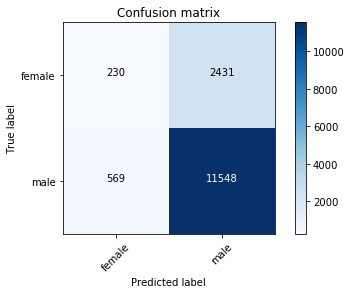

In [210]:
plot_confusion_matrix(confusion_matrix(X_test_label, cls.classify_many(X_test_value)), ['female','male'])